<h1 align='center'> Quora Insincere Quetions Prediction <h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

**Data fields**<br>
qid - unique question identifier<br>
question_text - Quora question text<br>
target - a question labeled "insincere" has a value of 1, otherwise 0<br>


## Table of Contents:

1. Data Import 
2. Exploratory Data Analysis
3. Feature Engineering
4. Trying Multiple Model - Multiple Metrics - accuracy, recall, precision, f1 - based on learning curve I like ~ better.
5. Imbalance in Data - SMOTE
6. Fine-Tuning - f1-weighted, ROC curve, validation curve
7. Insights from the Models -> feature importance
8. Further - Error Analysis

In [2]:
import warnings
warnings.filterwarnings("ignore")

# data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text handling
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ml
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, StratifiedKFold, 
                                        cross_val_score, learning_curve, validation_curve, cross_val_predict)
from sklearn.metrics import (make_scorer, confusion_matrix, accuracy_score,
                            precision_recall_fscore_support, f1_score, classification_report)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Imputer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

# DL 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, LSTM, Dense

from tqdm import tqdm
import nltk
from functools import partial
import string

plt.style.use('fivethirtyeight')
%matplotlib inline


## Data Import

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
print("rows: {}, columns: {}".format(*df.shape))

rows: 1306122, columns: 3


In [5]:
print("There are {} missing values".format(df.isnull().sum().sum()))

There are 0 missing values


In [6]:
print("Unique targets: {}".format(df['target'].unique()))

Unique targets: [0 1]


In [7]:
# Every ID is unique!
print("Is every ID unique? :", len(df['qid'].unique()) == df.shape[0])

Is every ID unique? : True


<br>

## Exploratory Data Anaylsis 

### First, see the examples of each class

In [8]:
# Examples of insincere texts
pd.options.display.max_colwidth = 100
df[df['target']==1].sample(10)

,qid,question_text,target
1169968,e5465e209c20de7dd56b,Why does the majority of Americans feel uneducated and less intellectual?,1
312777,3d47177042b321124f5e,"Which are your best colors for 4x8, corrugated plastic sheets?",1
489290,5fd4317e1e51c6c7bdc7,Do Chinese people eat mercury thinking it is a kind of elixir?,1
591720,73e5e93f54b9afa87e71,Did George W. Bush really have a gay affair with Barack Obama?,1
1193267,e9dcd245282dfa716298,How had ISIS boosted Tatiana Estévez' subjective sex-life with her fetish for murderously exploi...,1
800092,9cc67b22c0a18c64cbd3,California residents are upset because the Trump sons shot and killed two endangered species on ...,1
1252138,f55f533e103119f302ee,"Scientifically speaking, is Donald the missing link?",1
646891,7eb119700364d0443d15,"What is the average intelligence (average IQ, test scores, any calculated metric) of the average...",1
985011,c0fc56cbe82205baaa3b,Is Trump the Evangelical Pope?,1
1215817,ee47a47fda08520fad4e,Why can’t some leftists grasp basic economics?,1


In [9]:
# Examples of sincere texts
df[df['target']==0].sample(10)

,qid,question_text,target
167412,20b6966f88e26799c75f,Does Any college give addmission in bsc post nursing in month of october?,0
297742,3a4ab14ffbb3c8f2f37f,What are the chances of nerve damage from wisdom teeth removal?,0
368362,4837b2837b990d3ae6c7,When is a good time to introduce a girlfriend to kids of separated parents?,0
424757,53427dd29a9d424e50bf,There seems to be a recurring fascination in Western English speaking culture with sisters. Are ...,0
865571,a99749bb91cc1fa450a9,Should the Mongolian alphabet have been latinized rather than cyrillicized?,0
982381,c075a366e05f14fe429a,Where do I sell my old and used Business Equipment in US?,0
679512,8514edd2a425a69bcb4b,Is it better to leave someone unaware of their impending annihilation?,0
554807,6cb436c337a27d27a07b,What is the legal process for a startup?,0
499579,61ce4c84912917ad646d,How do I declutter my life if I'm in high school?,0
713403,8ba5ae1325e47c1d72c1,Where would we find part time jobs?,0


## 1. Proportion of target class?
## 2. Average lengths of the text of each class?

### Findings

- There is severe imbalance detected in the target class. This imbalance makes the evaluation and training of classifiers far harder. For example, the accuracy metrics is not a precise representation of the performance anymore. A classifier will always lean toward the majority class to get better accuracy.

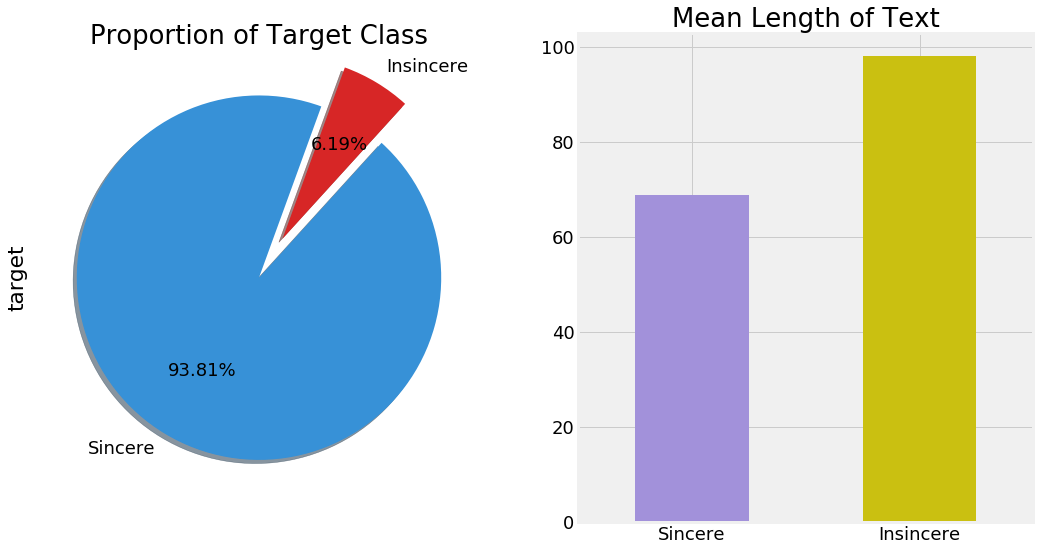

In [42]:
plt.rcParams['font.size'] = 18
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
labels=['Sincere', 'Insincere']
colors = ["#3791D7", "#D72626"]
df["target"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', 
                                             shadow=True, colors=colors, ax=ax1,
                                             labels=labels, startangle=70)

df['text_len'] = df['question_text'].map(len)
text_len_compare = df.groupby(['target'])['text_len'].mean()
text_len_compare.index=labels
text_len_compare.plot.bar(ax=ax2, color=['#A291DA', '#CAC011'], rot=0)

ax1.set_title('Proportion of Target Class')
ax2.set_title('Mean Length of Text')
plt.show()

# Empirical distribution of average text lengths

### Findings

- Mean text lengths could be a good indicator for distinguishing insincere questions from sincere questions. There is clear difference in there distribution and characteristic.

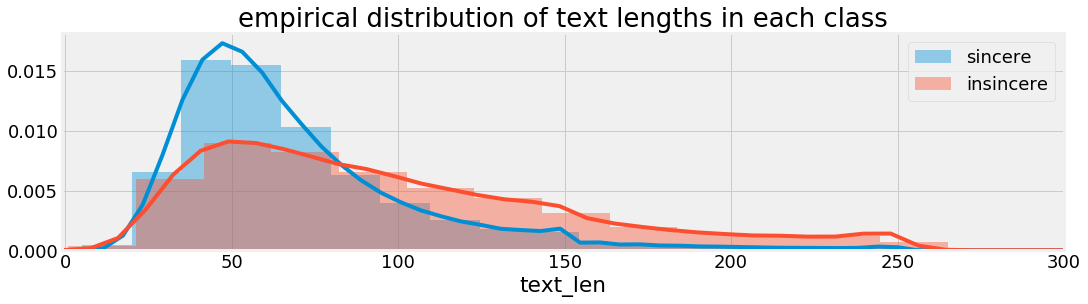

In [43]:
insincere = df[df['target']==1]
sincere = df[df['target']==0]

plt.figure(figsize=(16,4))
sns.distplot(sincere['text_len'], label='sincere')
sns.distplot(insincere['text_len'], label='insincere')

plt.legend()
plt.xlim(-1, 300)
plt.title('empirical distribution of text lengths in each class')
plt.show()

<br>

## What are the most common words in 'sincere' class? - best, good, learn, etc.

In [ ]:
def tokenize(txt):

    def tokenize(s): 
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        return re_tok.sub(r' ', s).split()
    
    token_txt = tokenize(txt)
    stops = set(nltk.corpus.stopwords.words('english'))
    stemmer = nltk.stem.SnowballStemmer('english')
    return [stemmer.stem(token) for token in token_txt if token not in stops]
    
    
def count_word(txt, count_dict):
    clean_txt = tokenize(txt)
    for word in clean_txt:
        count_dict[word] = count_dict.get(word, 0) + 1
    
sincere_word_counter = {}
sincere['question_text'].map(partial(count_word, count_dict=sincere_word_counter))

In [37]:
sorted_sincere_counter = sorted(sincere_word_counter.items(), key = lambda x: x[1], reverse=True)[:50]
printing = [row[0] for row in sorted_sincere_counter]

table_sincere = pd.DataFrame({'rank_1': printing[:10], 'rank_2':printing[10:20], 'rank_3':printing[20:30],
                             'rank_4':printing[30:40], 'rank_5':printing[40:50]})
table_sincere

,rank_1,rank_2,rank_3,rank_4,rank_5
0,what,use,year,life,becom
1,i,which,time,doe,mean
2,how,peopl,way,much,job
3,whi,good,work,go,thing
4,is,make,think,mani,engin
5,get,do,are,want,learn
6,best,one,take,know,find
7,would,if,someon,feel,happen
8,can,india,person,where,book
9,like,differ,who,start,ever


<br>

## What are the most common words in 'insincere' class? - trump, muslim, sex, etc.

In [ ]:
insincere_word_counter = {}
insincere['question_text'].map(partial(count_word, count_dict=insincere_word_counter))

In [40]:
sorted_insincere_counter = sorted(insincere_word_counter.items(), key = lambda x: x[1], reverse=True)[:50]
printing = [row[0] for row in sorted_insincere_counter]

table_insincere = pd.DataFrame({'rank_1': printing[:10], 'rank_2':printing[10:20], 'rank_3':printing[20:30],
                             'rank_4':printing[30:40], 'rank_5':printing[40:50]})
table_insincere

,rank_1,rank_2,rank_3,rank_4,rank_5
0,whi,do,black,hate,christian
1,peopl,muslim,mani,sex,right
2,i,american,girl,world,much
3,is,are,quora,say,democrat
4,how,white,countri,one,feel
5,trump,think,india,question,know
6,what,men,want,chines,go
7,like,would,liber,support,use
8,women,get,us,year,even
9,indian,if,make,kill,believ


### Findings

- Interestingly, looking at the 50 most common words already reveal severe difference between sincere and insincere questions. Sincere questions contain plain and common English words such as 'best', 'good', or 'learn.' On the other hand, insincere questions contain racial, sexual and geographical references such as 'muslim', 'white' or 'sex.'
- Ideally, following feature engineering steps should enable my models to learn those patterns for classification.

<br>

# Feature Engineering

### Approaches

- Here, I suggest two bag-of-words algorithms for feature extraction. They have multiple hyper-parameters for each. The order of n-grams, maximum number of featrues, or minimum frequencies should be searched over to identify the most informative input features.
- Three feature selectors are suggested. Each of them has its own statistical meaning.

In [11]:
# Tokenize
def preprocessing(titles):
    num_titles = titles.size
    
    clean_titles = []
    
    stops = set(stopwords.words("english"))
    
    for i in range(0, num_titles):
        #letters_only = re.sub("[^a-zA-Z]", " ", titles[i]) 
        words = titles[i].lower().split()
        words = [w.lower() for w in words if not w in stops]  
        clean_titles.append(" ".join(words))
        
    return clean_titles

# Tf-idf
def tf_idf(titles, ngram_range=(1,1), max_df=0.99, min_df=3, norm='l2'):

    tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                        max_df=max_df, min_df=min_df, norm=norm)
    vectors = tf_idf_vectorizer.fit_transform(titles)
    
    return vectors, tf_idf_vectorizer # This transformer will be used to vectorize test data again.

# counter
def count(titles, ngram_range=(1,1), max_df=0.99, min_df=3, max_features=None, binary=False):
    
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df,
                                           max_features=max_features, binary=binary)
    vectors = count_vectorizer.fit_transform(titles)
    
    return vectors, count_vectorizer

In [12]:
# Feature Selection
from sklearn.tree import DecisionTreeClassifier, tree
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


def features_chi2(features, labels, n_features=5000):
    chi2_model = SelectKBest(chi2, k=n_features)
    new_features = chi2_model.fit_transform(features, labels)
    return new_features, chi2_model

def features_information_gain(features, labels, max_features=1000):
    tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_features=max_features)
    tree_clf = tree_clf.fit(features, labels)
    inf_gain = SelectFromModel(tree_clf, prefit=True)
    new_features = inf_gain.transform(features)
    return new_features, inf_gain
    
def features_lsa(features,n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    new_features = lsa.fit_transform(features)
    return new_features, lsa

In [13]:
vectors, tf_idf_vectorizer = tf_idf(df['question_text'].values, ngram_range=(1,1), max_df=0.99, min_df=3, norm='l2')
#vectors, counter_vectorizer = counter(df['question_text'].values, ngram_range=(1,1), max_df=1.0, min_df=1)b

In [16]:
labels = df['target'].values.reshape(-1, 1)

chi2_vec, chi2_model = features_chi2(vectors, labels, 150)
ig_vec, ig_model = features_information_gain(vectors, labels, 150)
lsa_vec, lsa_model = features_lsa(vectors, 150)

## Word lengths segmentation

### Approaches
- As mentioned, the lenths of words can be a potential indicator for classification. I will segement the levels into three: 'short', 'medium' and 'long'
- This ordinal categories are expected to give the model more inforamtion.

In [ ]:
levels = [0, 1, 2]
bins = [0, 25, 85, float('inf')]

word_len_category = pd.cut(df['text_len'], bins=bins, labels=levels).astype('int').values.reshape(-1, 1)

chi2_vec_cat = np.concatenate([chi2_vec.toarray(), word_len_category], axis=1)
ig_vec_cat = np.concatenate([ig_vec.toarray(), word_len_category], axis=1)
lsa_vec_cat = np.concatenate([lsa_vec.toarray(), word_len_category], axis=1)

### Stratified train and test set split

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit

X_train, X_test, y_train, y_test = StratifiedShuffleSplit(X, labels, test_size=0.2, stratify=y)

<br>

## Trying Multiple Models

## 1. Baseline: logistic regression

#### What is happening? 
- Without cross-validation, 


#### Approaches

In [18]:
# Initial Modeling
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
lr = LogisticRegression()

# Evaluate
vec_names = ['Chi2', 'IG', "LSA"]

# Fit the model
for i, vec in enumerate([chi2_vec_cat, ig_vec_cat, lsa_vec_cat]):
    test_val = cross_validate(lr, vec, labels, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=kfold)
    
    accuracy = round(test_val['test_accuracy'].mean(), 3)
    precision = round(test_val['test_precision'].mean(), 3)
    recall = round(test_val['test_recall'].mean(), 3)
    fscore = round(test_val['test_f1'].mean(), 3)
    
    print(vec_names[i], "Logistic", "- accuracy{0}, precision: {1}, recall: {2}, fscore: {3}"\
          .format(accuracy, precision, recall, fscore))

NameError: name 'y' is not defined

<br>

## 2. Cross-Validation: Closer Look into Bias & Variance Trade-Off

** Differences **

** Accuracy metrics can be misleading **

In [ ]:
# Evaluation
def custom_cross_validate(text_matrix, labels, classifier="SVM", n_splits=10):
    clf = None
    precision = []
    recall = []
    fscore = []
    
    if classifier == "RF":
        clf = RandomForestClassifier()
    elif classifier == "NB":
        clf = MultinomialNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    elif classifier == "XGB":
        clf = XGBClassifier()
    elif classifier == "KNN":
        clf = KNeighborsClassifier()
        
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(X=np.zeros(len(labels)), y=labels):
        clone_clf = clone(clf)
        X_train, X_test = text_matrix[train_index], text_matrix[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        clone_clf.fit(X_train, y_train)
        
        y_pred = clone_clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        
    return round(np.mean(precision),3), round(np.mean(recall),3), round(np.mean(fscore),3)

In [ ]:
kfold = StratifiedKFold(n_splits=3)

acc_cross = {}
for i, pred in enumerate(short_predictors):
    acc_temp = cross_val_score(pred, short_X_train, np.array(short_y_train).ravel(), scoring='f1_micro', 
                               cv=kfold, n_jobs=-1)
    acc_cross['{}'.format(names[i])] = acc_temp.mean()
    

In [ ]:
for key, val in acc_cross.items():
    print(f"{key} : {val}")

In [ ]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(14, 5))
sns.barplot(short_pred_names, list(acc_cross.values()))
plt.show()

<br>

## 3. Learning Curve - Performance vs. Number of Training Samples

** Approaches **

** Findings **

In [ ]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param):
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - 3*train_scores_std,
                train_scores_mean + 3*train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - 3*test_scores_std,
                test_scores_mean + 3*test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel('Accuracy')
    plt.title("{} Accuracy vs. {}".format(name_pred, name_param))
    plt.show()
    
def plot_learning_curve(predictor, X, y, name_param, name_pred, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, cv=cv, scoring='f1_weighted')
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param)
    
plot_learning_curve(RandomForestClassifier(), short_X_train, short_y_train, "Training Samples", "Random Forest")

In [ ]:
# Learning Curve
def plot_learning_curve(predictor, X, y, name_param, name_pred, scoring='accuracy', cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, scoring=scoring, cv=cv)
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param, scoring)
    
plot_learning_curve(lr, X_train, y_train, "Training Samples", "Logistic Regression", scoring="accuracy")

def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], scoring='accuracy', cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, 
                                                                                    scoring=scoring, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, sharex=False, sharey=False)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_xlabel('training samples')
        ax.set_ylabel(scoring)
        ax.set_title(names[i])
    

predictors = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo')]
pred_names = ['kn', 'nb', 'rf', 'xgb', 'svc']

plot_multiple_learning_curve(predictors, short_X_train, short_y_train, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names, scoring='accuracy', cv=3)

<br>

## 4. Validation Curve - Performance vs. Regularization Parameter

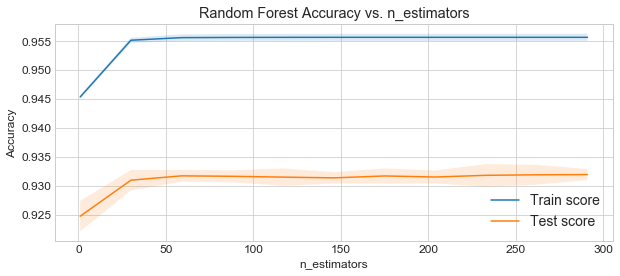

In [66]:
def plot_val_curve(predictor, X, y, name_param, name_pred, param_space, cv=3):
    train_scores, test_scores = validation_curve(predictor, X, y, name_param,
                                               param_space, cv=cv)
    call_plot(param_space, train_scores, test_scores, name_pred, name_param)
    
plot_val_curve(RandomForestClassifier(), short_X_train, short_y_train, 'n_estimators',
               'Random Forest', range(1, 300, 29))

<br>

## Hyperparameter Tuning - Random Search


In [185]:
# Hyperparameter grid
rf_param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, rf_param_grid, n_jobs = -1, 
                        scoring = 'f1_weighted', cv = kfold, 
                        n_iter = 10, verbose = 1)
rf_rs.fit(short_X_train, short_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.1s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94, ... 49, 50], 'min_samples_split': [2, 5, 10], 'boots

In [87]:
# A parameter grid for XGBoost
xg_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xg = XGBClassifier()
xg_rs = RandomizedSearchCV(xg, xg_param_grid, 
                                   n_iter=100, scoring='f1_micro', 
                                   n_jobs=-1, cv=kfold, verbose=3)
xg_rs.fit(short_X_train, np.array(short_y_train).ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_micro', verbose=3)

## Evaluation